In [9]:
import matplotlib.pyplot as plt
import json
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from numpy import dot
from numpy.linalg import norm
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from ast import literal_eval
import os
from tqdm import tqdm

In [10]:
def split_ids(id_string, n=8):
    # Convert to string if the input is not already a string
    id_string = str(id_string)
    # Assuming the hadm_id and stay_id are concatenated as one string
    # Convert hadm_id to float to match the format in the original dataset
    hadm_id = float(id_string[:8])  # Convert first part to float
    stay_id = int(id_string[8:])   # Convert remaining part to int
    return hadm_id, stay_id

In [11]:
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']  # This part was not used in the example provided

mm_dir = "/data/wang/junh/datasets/multimodal"
output_dir = os.path.join(mm_dir, "multiclass/weights/")

- 4 modalities

In [12]:
def assign_kl_4mods(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred, threshold=0.4):
    # Assuming that each 'Probs' column contains lists of probabilities for the 4 classes
    # Rename and merge data on 'ids'
    df = ts_pred[['ids', 'Probs']].rename(columns={'Probs': 'ts'})
    df = df.merge(text_pred[['ids', 'Probs']].rename(columns={'Probs': 'text'}), on='ids')
    df = df.merge(cxr_pred[['ids', 'Probs']].rename(columns={'Probs': 'cxr'}), on='ids')
    df = df.merge(ecg_pred[['ids', 'Probs']].rename(columns={'Probs': 'ecg'}), on='ids')
    df = df.merge(multi_pred[['ids', 'Probs']].rename(columns={'Probs': 'Multi'}), on='ids')
    for col in ['ts', 'text', 'cxr', 'ecg', 'Multi']:
        df[col] = df[col].apply(lambda x: np.array(literal_eval(x)))

    # Calculate KL divergence between each modality and the multimodal distribution
    for modality in ['ts', 'text', 'cxr', "ecg"]:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(row[modality], row['Multi']), axis=1)

    #print("kl columns head: \n", df[['kl_ts', 'kl_text', 'kl_cxr', 'kl_ecg']].head())

    return df

In [13]:
def update_stays_with_weights(file_path, kl_scores):
    with open(file_path, 'rb') as file:
        stays_list = pickle.load(file)

    match_count = 0
    unmatched_ids = []

    kl_id_set = set(kl_scores['ids'].astype(str))  # Ensure the IDs are treated as strings for consistent matching

    for stay in stays_list:
        for modality in ['ts', 'text', 'cxr', 'ecg']:
            stay[f'{modality}_weight'] = 0
        id_string = f"{int(stay['hadm_id']):08d}{int(stay['stay_id'])}"  # Format and pad ID as string if needed

        if id_string in kl_id_set:
            matching_row = kl_scores[kl_scores['ids'].astype(str) == id_string].iloc[0]
            stay['ts_weights'] = matching_row['kl_ts']
            stay['text_weights'] = matching_row['kl_text']
            stay['cxr_weights'] = matching_row['kl_cxr']
            stay['ecg_weights'] = matching_row['kl_ecg']
            match_count += 1
        else:
            unmatched_ids.append(id_string)

    with open(file_path, 'wb') as file:
        pickle.dump(stays_list, file)
        print(f"Updated and saved {file_path}")

    print(f"Matched {match_count} out of {len(stays_list)} records in {file_path}")

In [ ]:
# Example usage: train_los-48-cxr-notes-ecg_stays.pkl
for dataset in datasets:
    print(f"Starting los {dataset} dataset")
    ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/TS_{dataset}_results.csv')
    text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/Text_{dataset}_results.csv')
    cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/CXR_{dataset}_results.csv')
    ecg_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/ECG_{dataset}_results.csv')
    multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/TS_CXR_Text_ECG_{dataset}_results.csv')

    kl_scores = assign_kl_4mods(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred)
    file_path = f'/data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/{dataset}_los-48-cxr-notes-ecg_stays.pkl'
    new_stays_list = update_stays_with_weights(file_path, kl_scores)

Starting los train dataset
Updated and saved /data/wang/junh/datasets/multimodal/multiclass/weights/train_los-48-cxr-notes-ecg_stays.pkl
Matched 3624 out of 3624 records in /data/wang/junh/datasets/multimodal/multiclass/weights/train_los-48-cxr-notes-ecg_stays.pkl
Starting los val dataset
Updated and saved /data/wang/junh/datasets/multimodal/multiclass/weights/val_los-48-cxr-notes-ecg_stays.pkl
Matched 776 out of 777 records in /data/wang/junh/datasets/multimodal/multiclass/weights/val_los-48-cxr-notes-ecg_stays.pkl
Starting los test dataset
Updated and saved /data/wang/junh/datasets/multimodal/multiclass/weights/test_los-48-cxr-notes-ecg_stays.pkl
Matched 776 out of 777 records in /data/wang/junh/datasets/multimodal/multiclass/weights/test_los-48-cxr-notes-ecg_stays.pkl


# Initialize

In [4]:
def initial_weights(file_path):
    with open(file_path, 'rb') as file:
        stays_list = pickle.load(file)

    for stay in tqdm(stays_list):
        # Initialize weights to 0 by default
        for modality in ['ts', 'text', 'cxr', 'ecg']:
            stay[f'{modality}_weight'] = 1

    with open(file_path, 'wb') as file:
        pickle.dump(stays_list, file)
    print(f"Updated and saved {file_path}")

In [6]:
# Example usage: train_los-48-cxr-notes-ecg_stays.pkl
for dataset in datasets:
    print(f"Starting los {dataset} dataset")

    file_path = f'/data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/{dataset}_los-48-cxr-notes-ecg_stays.pkl'
    new_stays_list = initial_weights(file_path)

Starting los train dataset


100%|██████████| 3624/3624 [00:00<00:00, 577425.84it/s]


Updated and saved /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/train_los-48-cxr-notes-ecg_stays.pkl
Starting los val dataset


100%|██████████| 777/777 [00:00<00:00, 394310.25it/s]


Updated and saved /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/val_los-48-cxr-notes-ecg_stays.pkl
Starting los test dataset


100%|██████████| 777/777 [00:00<00:00, 514927.19it/s]


Updated and saved /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/test_los-48-cxr-notes-ecg_stays.pkl


# With Missing

In [7]:
def assign_pid_4probs(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred):
    # Merge predictions
    df = ts_pred[['ids', 'Probs']].rename(columns={'Probs': 'ts'})
    df = df.merge(text_pred[['ids', 'Probs']], on='ids', how='left').rename(columns={'Probs': 'text'})
    df = df.merge(cxr_pred[['ids', 'Probs']], on='ids', how='left').rename(columns={'Probs': 'cxr'})
    df = df.merge(ecg_pred[['ids', 'Probs']], on='ids', how='left').rename(columns={'Probs': 'ecg'})
    df = df.merge(multi_pred[['ids', 'Probs']].rename(columns={'Probs': 'Multi'}), on='ids', how='left').dropna()

    # Convert probability strings to arrays
    modalities = ['ts', 'text', 'cxr', 'ecg', 'Multi']
    for col in modalities:
        df[col] = df[col].apply(lambda x: np.array(literal_eval(x)) if pd.notnull(x) else np.array([0]*4))  # Assuming 4 classes

    # Initialize KL divergence columns with default 0
    for modality in modalities[:-1]:  # Exclude 'Multi'
        df[f'kl_{modality}'] = 0

    # Calculate KL divergence where data is available
    for modality in modalities[:-1]:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(row[modality], row['Multi']) if np.sum(row[modality]) != 0 else 0, axis=1)

    # Normalize KL divergence scores across the dataset
    for modality in modalities[:-1]:
        max_kl = df[f'kl_{modality}'].max()
        min_kl = df[f'kl_{modality}'].min()
        range_kl = max_kl - min_kl
        if range_kl > 0:
            df[f'kl_{modality}'] = (df[f'kl_{modality}'] - min_kl) / range_kl
        else:
            df[f'kl_{modality}'] = 0  # Avoid division by zero if all values are the same

    return df

In [8]:
def update_stays_with_weights(file_path, kl_scores):
    with open(file_path, 'rb') as file:
        stays_list = pickle.load(file)

    match_count = 0

    for stay in tqdm(stays_list):
        # Initialize weights to 0 by default
        for modality in ['ts', 'text', 'cxr', 'ecg']:
            stay[f'{modality}_weight'] = 0

        # Generate ID string
        id_string = f"{int(stay['hadm_id']):08d}{int(stay['stay_id'])}"
        
        # Check for matching row in kl_scores
        if id_string in kl_scores['ids'].astype(str).values:
            matching_row = kl_scores[kl_scores['ids'].astype(str) == id_string].iloc[0]
            
            for modality in ['ts', 'text', 'cxr', 'ecg']:
                if stay.get(f'{modality}_missing', 0) == 0:  # Check if the modality data is not missing
                    stay[f'{modality}_weight'] = matching_row[f'kl_{modality}']
            match_count += 1

    with open(file_path, 'wb') as file:
        pickle.dump(stays_list, file)
    print(f"Updated and saved {file_path}")
    print(f"Matched {match_count} out of {len(stays_list)} records in {file_path}")

In [6]:
# Example usage: train_los-48-cxr-notes-ecg_stays.pkl
for dataset in datasets:
    print(f"Starting los {dataset} dataset")
    ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/missingInd/TS_{dataset}_results.csv')
    print("number of ts_pred: ", len(ts_pred))
    text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/missingInd/Text_{dataset}_results.csv')
    print("number of text_pred: ", len(text_pred))
    cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/missingInd/CXR_{dataset}_results.csv')
    print("number of cxr_pred: ", len(cxr_pred))
    ecg_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/missingInd/ECG_{dataset}_results.csv')
    print("number of ecg_pred: ", len(ecg_pred))
    multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/missingInd/TS_CXR_Text_ECG_{dataset}_results.csv')
    print("number of multi_pred: ", len(multi_pred))

    kl_scores = assign_pid_4probs(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred)
    file_path = f'/data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/{dataset}_los-48-cxr-notes-ecg-missingInd_stays.pkl'
    new_stays_list = update_stays_with_weights(file_path, kl_scores)

Starting los train dataset
number of ts_pred:  24590
number of text_pred:  24590
number of cxr_pred:  24590
number of ecg_pred:  24590
number of multi_pred:  24590


100%|██████████| 24591/24591 [06:33<00:00, 62.51it/s]


Updated and saved /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/train_los-48-cxr-notes-ecg-missingInd_stays.pkl
Matched 24586 out of 24591 records in /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/train_los-48-cxr-notes-ecg-missingInd_stays.pkl
Starting los val dataset
number of ts_pred:  5264
number of text_pred:  5264
number of cxr_pred:  5264
number of ecg_pred:  5264
number of multi_pred:  5264


100%|██████████| 5270/5270 [00:19<00:00, 274.10it/s]


Updated and saved /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/val_los-48-cxr-notes-ecg-missingInd_stays.pkl
Matched 5264 out of 5270 records in /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/val_los-48-cxr-notes-ecg-missingInd_stays.pkl
Starting los test dataset
number of ts_pred:  5264
number of text_pred:  5264
number of cxr_pred:  5264
number of ecg_pred:  5264
number of multi_pred:  5264


100%|██████████| 5270/5270 [00:20<00:00, 260.06it/s]


Updated and saved /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/test_los-48-cxr-notes-ecg-missingInd_stays.pkl
Matched 5264 out of 5270 records in /data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/test_los-48-cxr-notes-ecg-missingInd_stays.pkl


In [10]:
import pickle
file_path = '/data/wang/junh/datasets/multimodal/multiclass/dynamic_weights/test_los-48-cxr-notes-ecg-missingInd_stays.pkl'
with open(file_path, 'rb') as f:
    train_stays_list = pickle.load(f)
print(len(train_stays_list))

5270


In [8]:
train_stays_list[0]['ts_weight']

0.002675114417258665

In [13]:
kl_scores = kl_scores.dropna()
kl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5264 entries, 0 to 5263
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ids      5264 non-null   int64  
 1   ts       5264 non-null   object 
 2   text     5264 non-null   object 
 3   cxr      5264 non-null   object 
 4   ecg      5264 non-null   object 
 5   Multi    5264 non-null   object 
 6   kl_ts    5264 non-null   float64
 7   kl_text  5264 non-null   float64
 8   kl_cxr   5264 non-null   float64
 9   kl_ecg   5264 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 452.4+ KB


In [15]:
kl_scores.head()

,ids,ts,text,cxr,ecg,Multi,kl_ts,kl_text,kl_cxr,kl_ecg
0,2480257938466097,"[0.3502248525619507, 0.5153291821479797, 0.112...","[0.37129926681518555, 0.46344518661499023, 0.1...","[0.30412352085113525, 0.6616771221160889, 0.03...","[0.26731982827186584, 0.502354085445404, 0.170...","[0.3205856680870056, 0.5347868800163269, 0.113...",0.002675,0.008458,0.038272,0.013578
1,2642353037015935,"[0.29364702105522156, 0.5780292749404907, 0.10...","[0.22132888436317444, 0.44253551959991455, 0.2...","[0.3352275490760803, 0.6318161487579346, 0.030...","[0.33013617992401123, 0.44948339462280273, 0.1...","[0.2819814085960388, 0.5675358772277832, 0.110...",0.002488,0.075768,0.039003,0.015176
2,2135896832114670,"[0.622501790523529, 0.3498745262622833, 0.0233...","[0.5864822864532471, 0.36486706137657166, 0.04...","[0.32254672050476074, 0.6414607763290405, 0.03...","[0.26795363426208496, 0.4928421378135681, 0.17...","[0.6230888962745667, 0.3478187024593353, 0.024...",0.000000,0.004471,0.092890,0.224474
3,2621648034997302,"[0.35394081473350525, 0.5282239317893982, 0.09...","[0.3747819662094116, 0.4641517400741577, 0.114...","[0.1926640272140503, 0.42354831099510193, 0.30...","[0.45571476221084595, 0.3739466965198517, 0.13...","[0.23463308811187744, 0.5592939853668213, 0.16...",0.040791,0.035767,0.041065,0.058726
4,2333589937101836,"[0.5050340294837952, 0.4413596987724304, 0.044...","[0.585262656211853, 0.36553338170051575, 0.043...","[0.3049400746822357, 0.6621591448783875, 0.030...","[0.32884877920150757, 0.3949761986732483, 0.14...","[0.5684288144111633, 0.3895321488380432, 0.027...",0.010210,0.005155,0.078545,0.174203


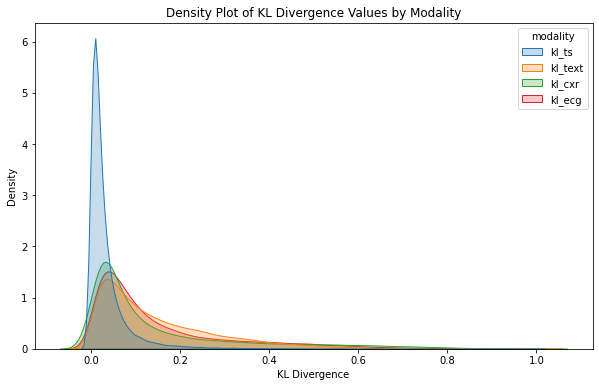

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# pivot the dataframe from long to wide form
result = all_kl_scores[['ids', 'kl_ts', 'kl_text', 'kl_cxr', 'kl_ecg']]
# Melting the DataFrame to make 'modality' as a variable and 'kl_values' as the value
df_melted = result.melt(id_vars='ids', value_vars=['kl_ts', 'kl_text', 'kl_cxr', 'kl_ecg'], 
                    var_name='modality', value_name='kl_values')

# Plotting the density plot for each modality
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_melted, x='kl_values', hue='modality', fill=True)
plt.title('Density Plot of KL Divergence Values by Modality')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.show()

In [10]:
result.describe()

,ids,kl_ts,kl_text,kl_cxr,kl_ecg
count,3.511400e+04,35114.000000,35114.000000,35114.000000,35114.000000
mean,2.498875e+15,0.035396,0.149604,0.153483,0.150393
std,2.883322e+14,0.058031,0.137493,0.187456,0.158250
min,2.000081e+15,0.000000,0.000000,0.000000,0.000000
25%,2.249981e+15,0.007443,0.046113,0.030232,0.041309
50%,2.499293e+15,0.017649,0.104551,0.070577,0.088767
75%,2.747322e+15,0.038924,0.216213,0.197897,0.199394
max,2.999963e+15,1.000000,1.000000,1.000000,1.000000


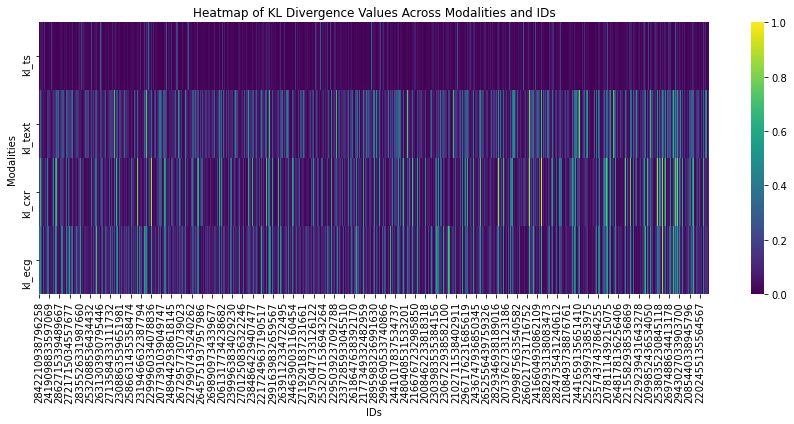

In [29]:
from pandas.plotting import parallel_coordinates

result = all_kl_scores[['ids', 'kl_ts', 'kl_text', 'kl_cxr', 'kl_ecg']]

result.set_index('ids', inplace=True)

# Transposing the DataFrame so that modalities become rows and IDs become columns
df_transposed = result.transpose()

# Normalize or scale the data if necessary
# df_transposed = (df_transposed - df_transposed.min()) / (df_transposed.max() - df_transposed.min())  # Uncomment if normalization is needed

# Plotting the heatmap
plt.figure(figsize=(15, 5))  # Adjust the figure size based on the actual number of IDs
sns.heatmap(df_transposed, annot=False, cmap='viridis', cbar=True)
plt.title('Heatmap of KL Divergence Values Across Modalities and IDs')
plt.xlabel('IDs')
plt.ylabel('Modalities')
plt.show()